## Problem statement - Client wants us to build a model that helps in predicting the yield output of a gas turbine located in one of the cities of Turkey

## Given dataset is of a gas turbine along with its yield & many other features listed below
### AT - Ambient Temperature (C)
### AP - Ambient Pressure (mbar)
### AH - Ambient Humidity (%)
### AFDP - Air Filter Difference Pressure (mbar)
### GTEP - Gas Turbine Exhaust Pressure (mbar)
### TIT - Turbine Inlet Temperature (C)
### TAT - Turbine After Temperature (C)
### TEY - Turbine Energy Yield (Target) (mwh)
### CDP - Compressor Discharge Pressure (mbar)
### CO - Carbon Monoxide (mg/m3)
### NOX - Nitrogen Oxides (mg/m3)

In [33]:
# Importing required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import fasttreeshap,shap
from joblib import Parallel,delayed

In [34]:
# Reading the data
df=pd.read_csv("C:\\Users\\palad\\OneDrive\\Desktop\\Datasets\\Regression datasets\\gas_turbine.csv")

In [35]:
# Viewing the first 5 rows
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [36]:
# Basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


### Initial Observations
### 1. There are a total of 36733 observations/entries & 11 features/columns
### 2. All of the features are numerical in nature
### 3. Given various independent features like pressure, temperature, humidity etc., of a gas turbine, its output energy needs to be predicted

In [37]:
# Statistical summary of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,36733.0,17.712726,7.447451,-6.234800,11.7810,17.8010,23.6650,37.1030
AP,36733.0,1013.070165,6.463346,985.850000,1008.8000,1012.6000,1017.0000,1036.6000
AH,36733.0,77.867015,14.461355,24.085000,68.1880,80.4700,89.3760,100.2000
AFDP,36733.0,3.925518,0.773936,2.087400,3.3556,3.9377,4.3769,7.6106
GTEP,36733.0,25.563801,4.195957,17.698000,23.1290,25.1040,29.0610,40.7160
TIT,36733.0,1081.428084,17.536373,1000.800000,1071.8000,1085.9000,1097.0000,1100.9000
TAT,36733.0,546.158517,6.842360,511.040000,544.7200,549.8800,550.0400,550.6100
TEY,36733.0,133.506404,15.618634,100.020000,124.4500,133.7300,144.0800,179.5000
CDP,36733.0,12.060525,1.088795,9.851800,11.4350,11.9650,12.8550,15.1590
CO,36733.0,2.372468,2.262672,0.000388,1.1824,1.7135,2.8429,44.1030


## Observations from the basic overview of the dataset
### 1. Yield varies from 100 mwh to 179.5 mwh
### 2. Carbon Monoxide Emission varies from 0.000388 mg/m3 to 44.10 mg/m3
### 3. Need to check the observation where the CO emission was 0.000388 for a typo error or any other error
### 4. Nitrogen Oxide Emission varies from 25.9 mg/m3 to 119.91 mg/m3

In [38]:
# Checking for the carbon monoxide emission of 0.000388
df.sort_values(by='CO')

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
29589,11.2880,1013.4,89.154,4.8104,32.604,1100.1,529.86,161.19,14.060,0.000388,65.630
33729,32.0570,1002.0,63.151,4.3993,29.196,1099.8,543.99,144.57,13.029,0.001594,54.057
7467,12.6850,1019.4,85.030,3.3272,24.829,1076.2,549.91,132.99,11.901,0.001640,98.520
33687,31.7890,1007.9,56.296,4.4652,29.667,1100.0,542.04,145.70,13.145,0.003665,54.238
16531,11.2000,1015.2,90.652,4.2741,32.786,1100.0,529.57,160.25,13.958,0.005033,57.139
...,...,...,...,...,...,...,...,...,...,...,...
1584,11.2570,1007.6,84.412,2.7025,19.879,1018.8,533.36,102.79,10.185,41.097000,75.444
21956,5.0232,1017.8,87.114,3.8648,21.435,1032.5,524.71,113.60,11.029,43.397000,92.062
21955,5.6602,1018.3,86.968,3.8404,21.079,1028.5,523.86,112.02,10.963,43.428000,99.237
36287,12.3620,1022.5,88.415,3.6979,21.238,1034.7,528.02,112.10,10.996,43.622000,80.193


## Conclusion on carbon monoxide emission of 0.000388 - Values seem real with no typo errors

## Exploratory Data Analysis
### Univariate Analysis

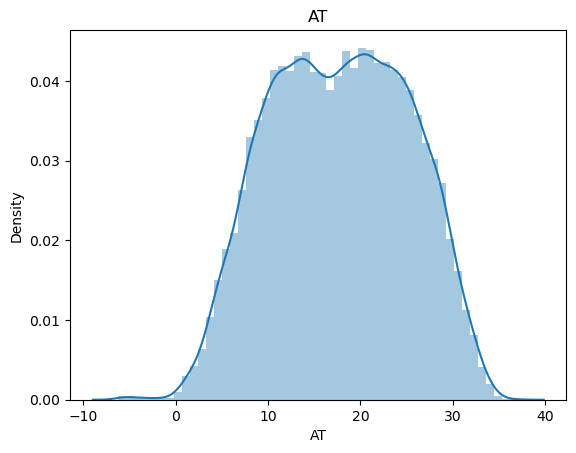

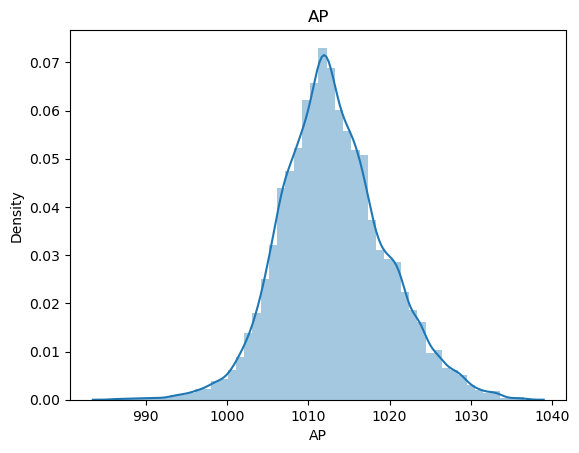

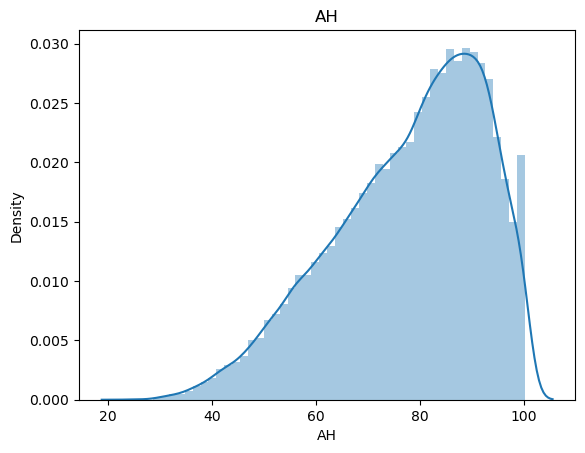

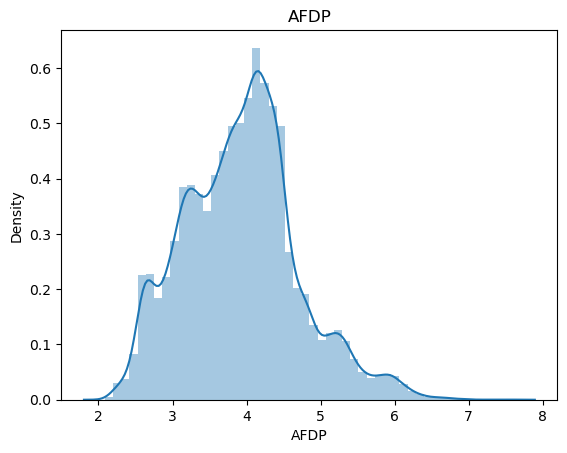

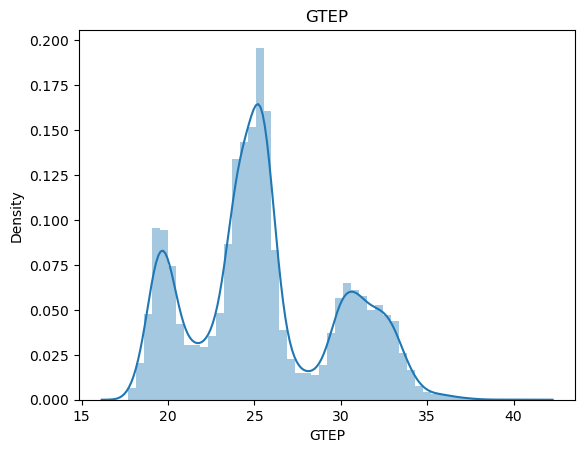

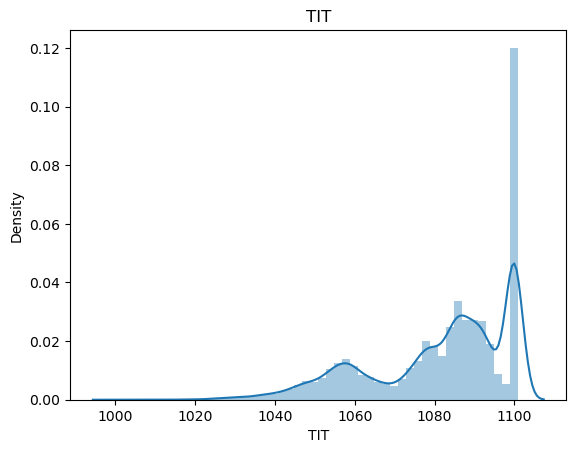

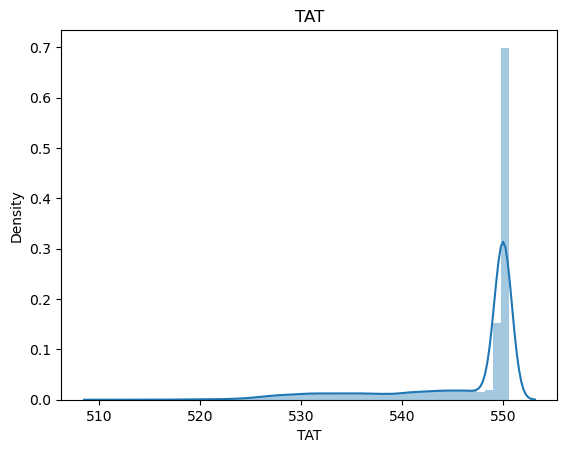

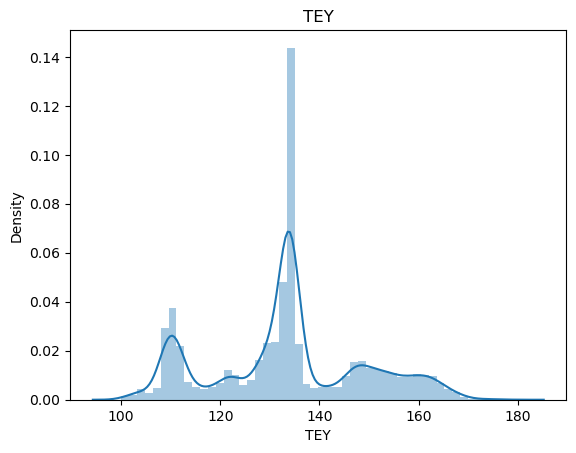

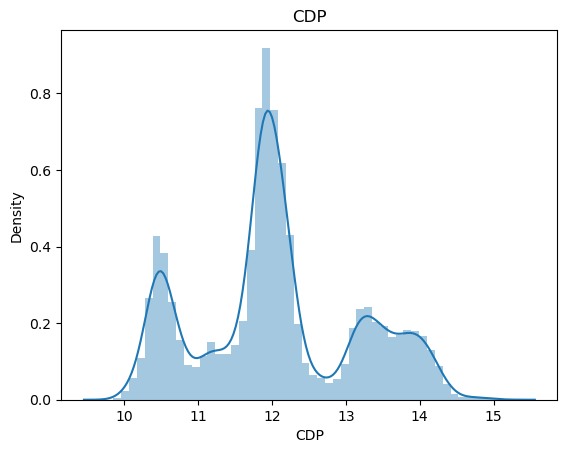

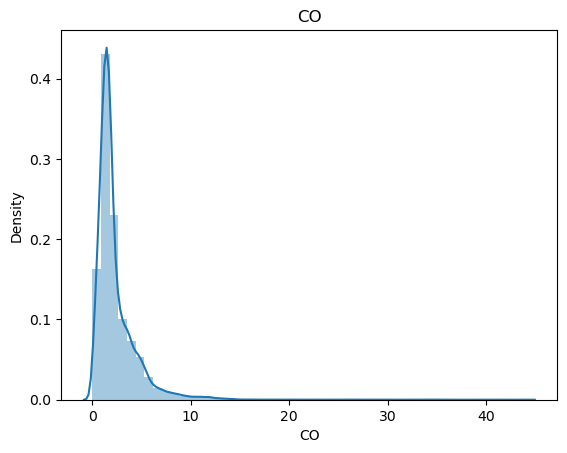

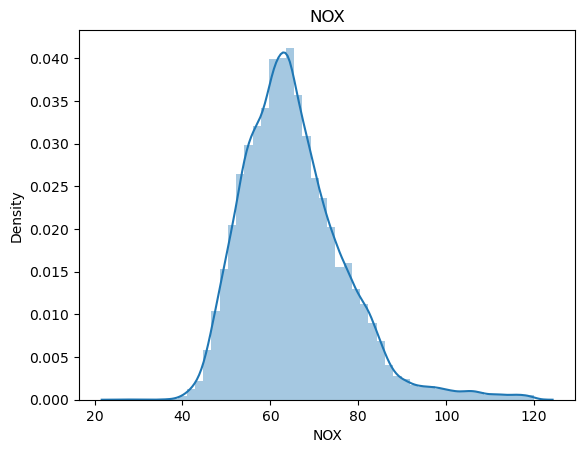

In [39]:
# Checking for distribution of all the variables
for i in df.columns:
    plt.figure()
    plt.title(i)
    sns.distplot(df[i]);

In [40]:
# Creating a list of all the independent variables
num_cols=df.columns.tolist()
num_cols.remove('TEY')

In [41]:
# Checking its components
num_cols

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'CDP', 'CO', 'NOX']

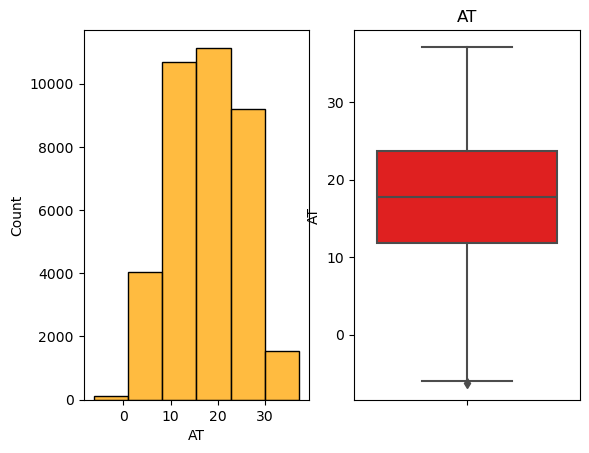

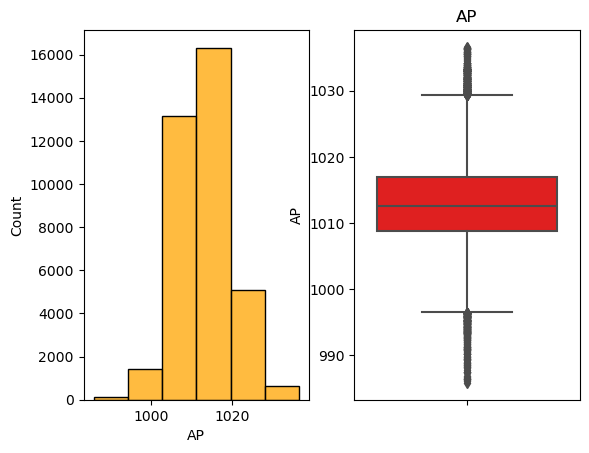

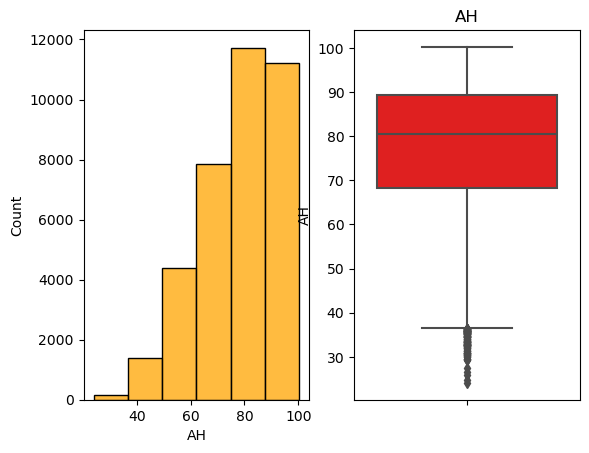

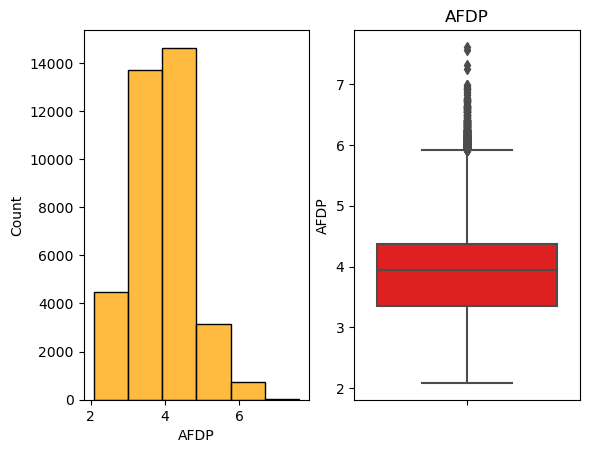

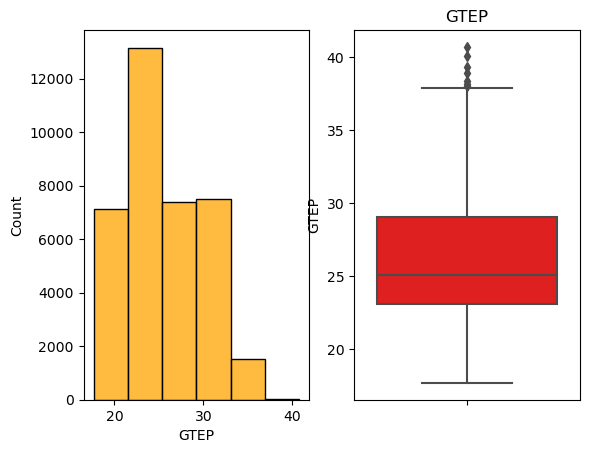

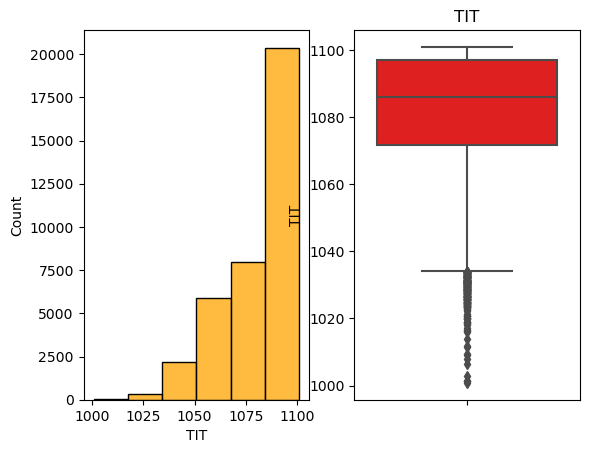

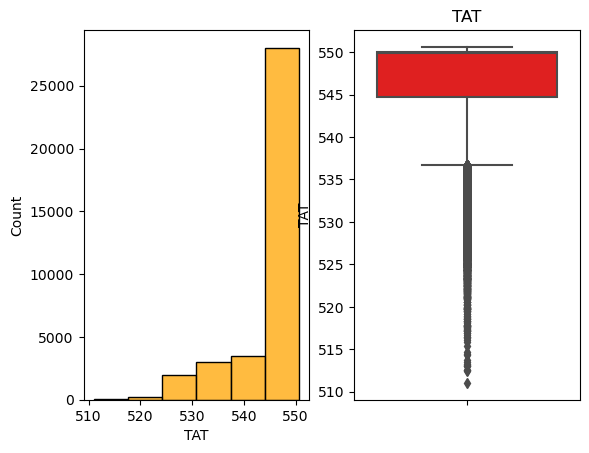

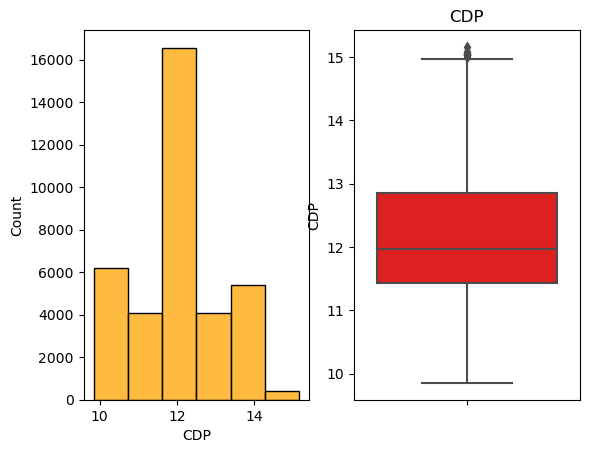

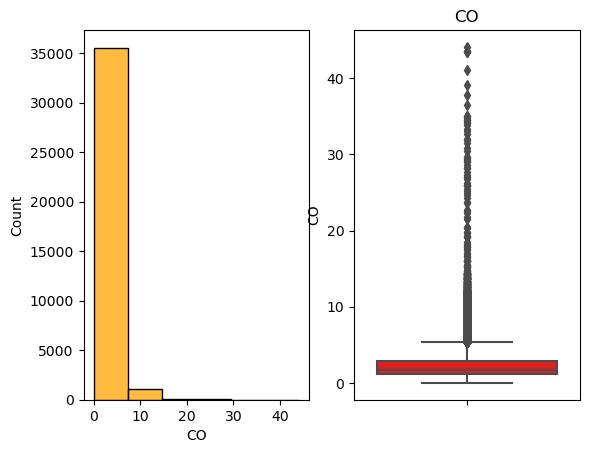

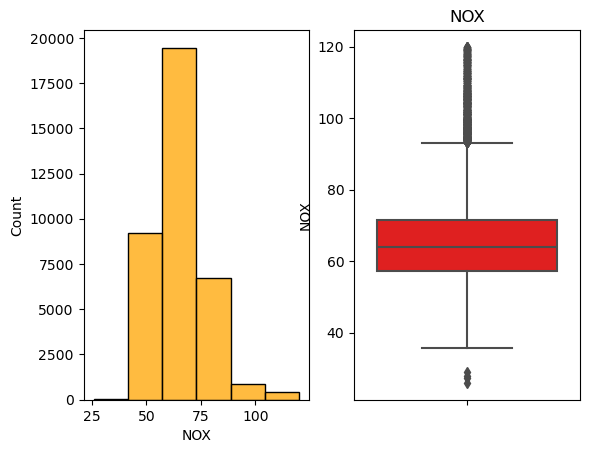

In [42]:
# Plotting histograms & boxplots of all the numerical varables
for i in num_cols:
    plt.figure()
    plt.subplot(121)
    sns.histplot(x=i,data=df,bins=6,color='orange')
    plt.subplot(122)
    plt.title(i)
    sns.boxplot(y=i,data=df,color='red');

### Bivariate Analysis

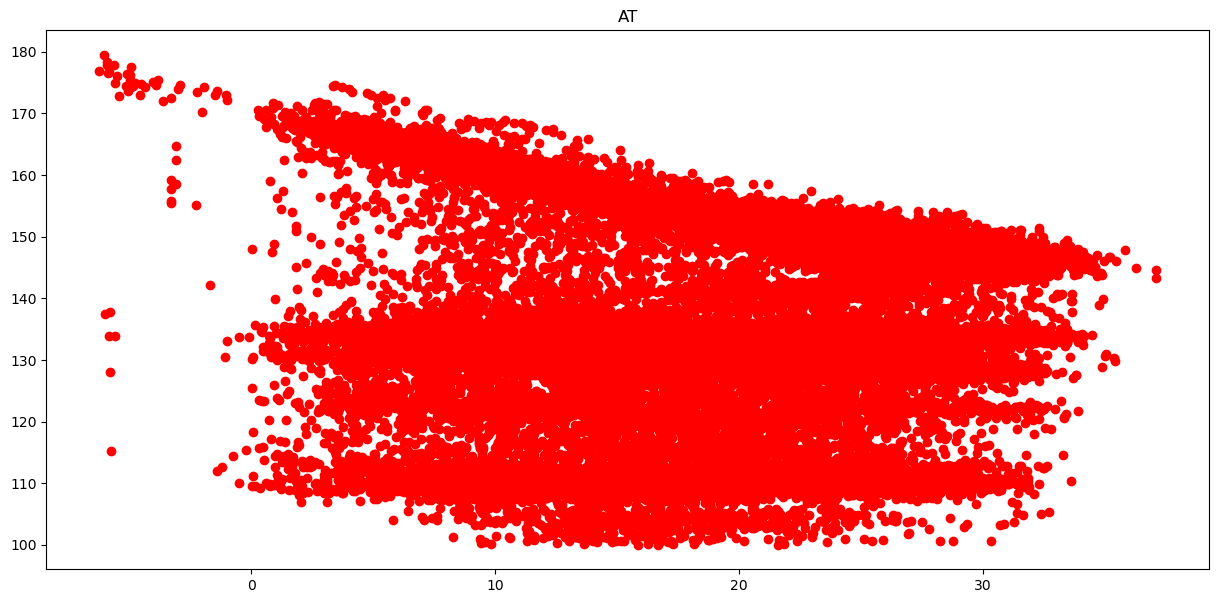

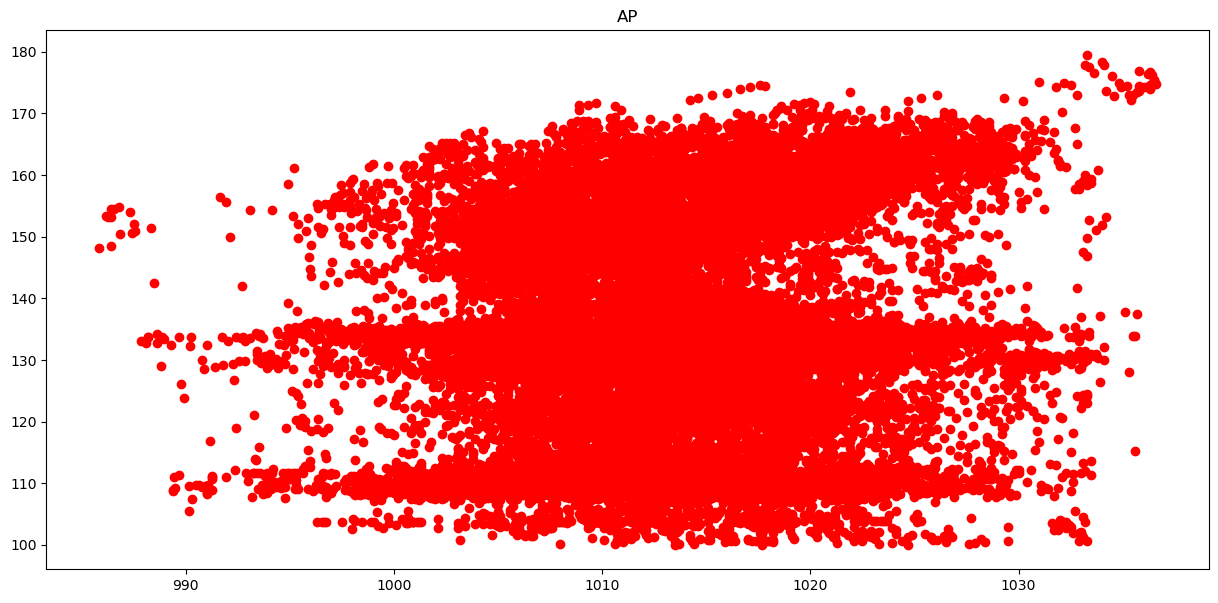

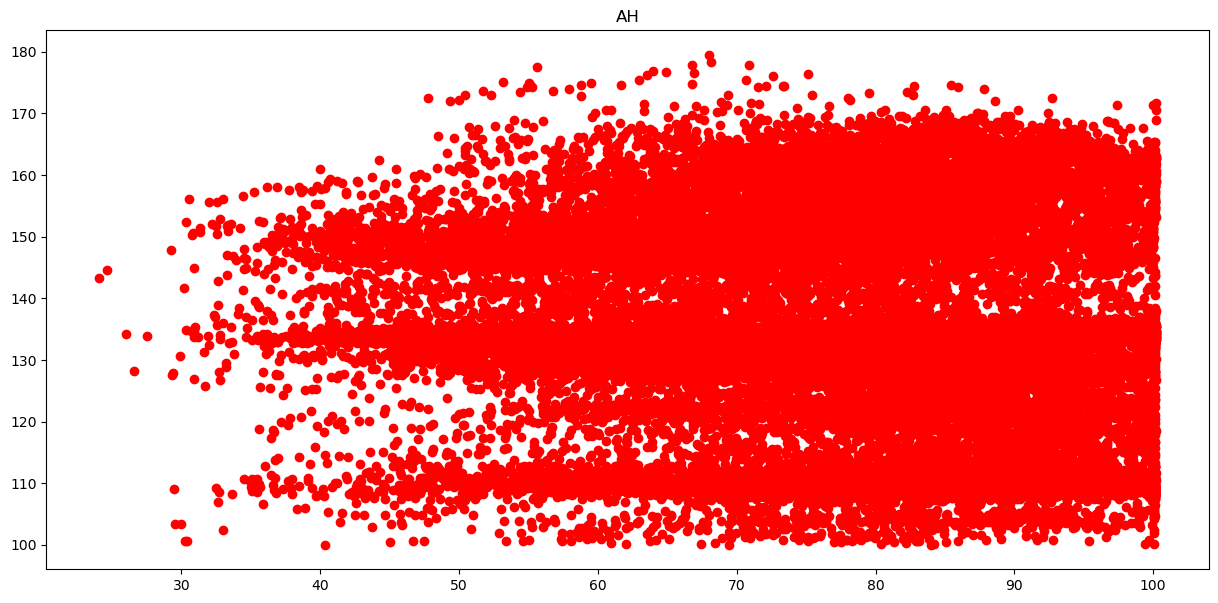

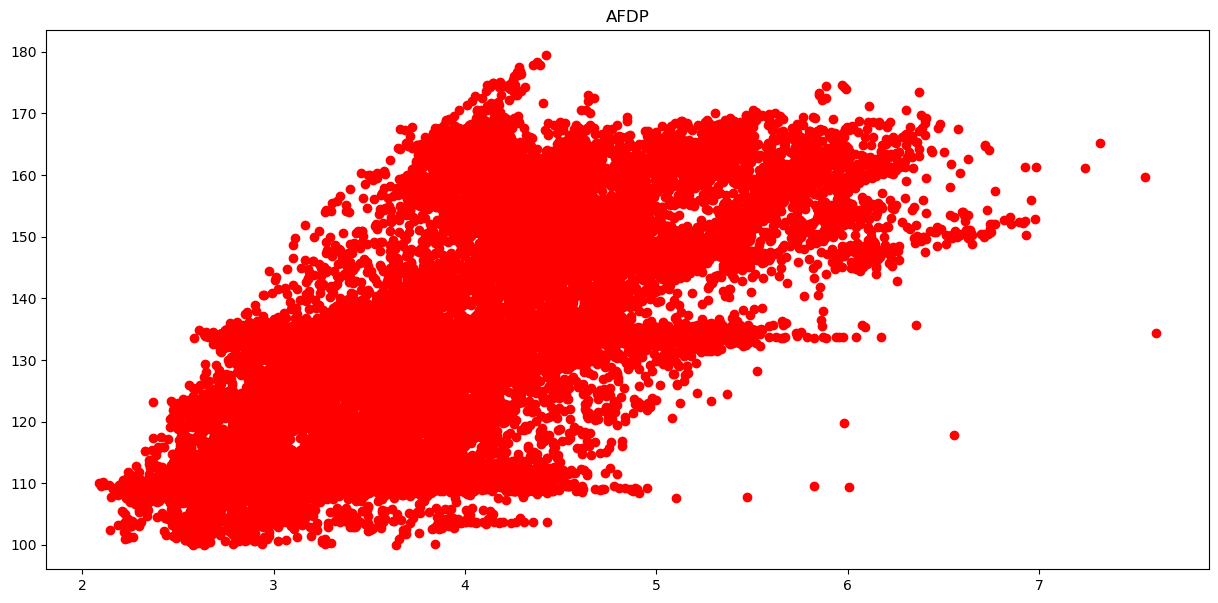

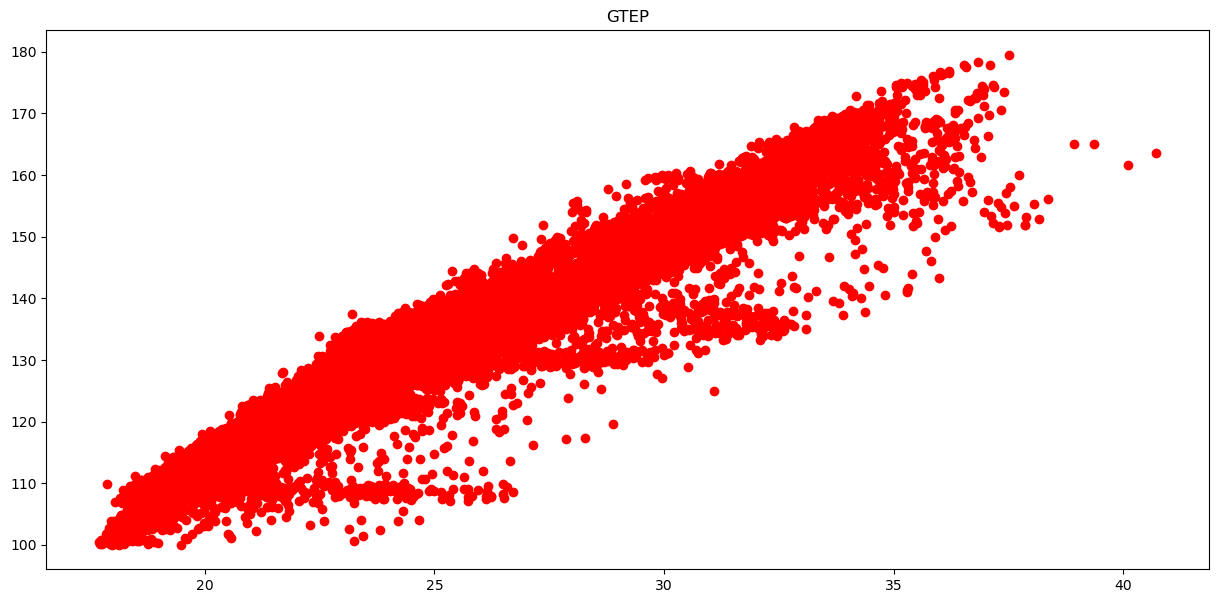

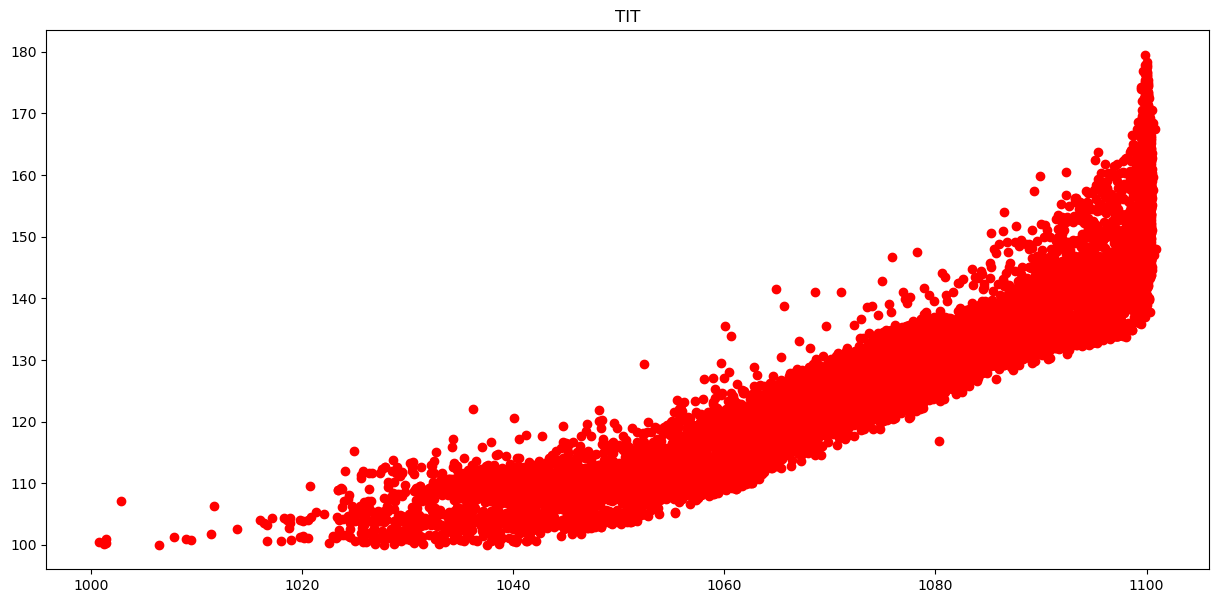

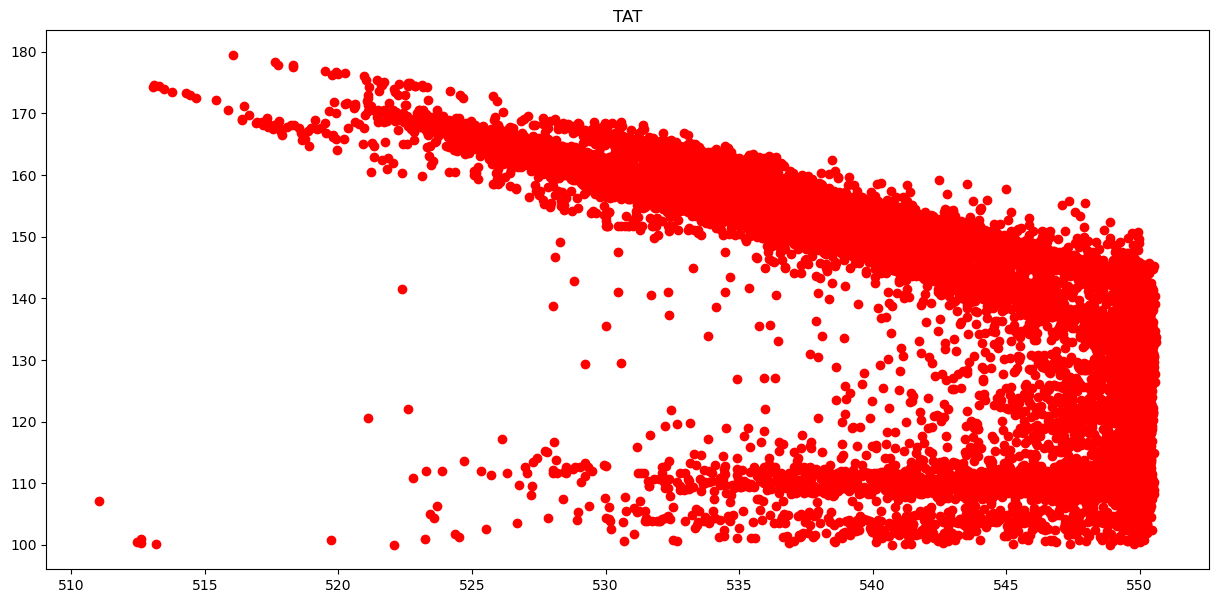

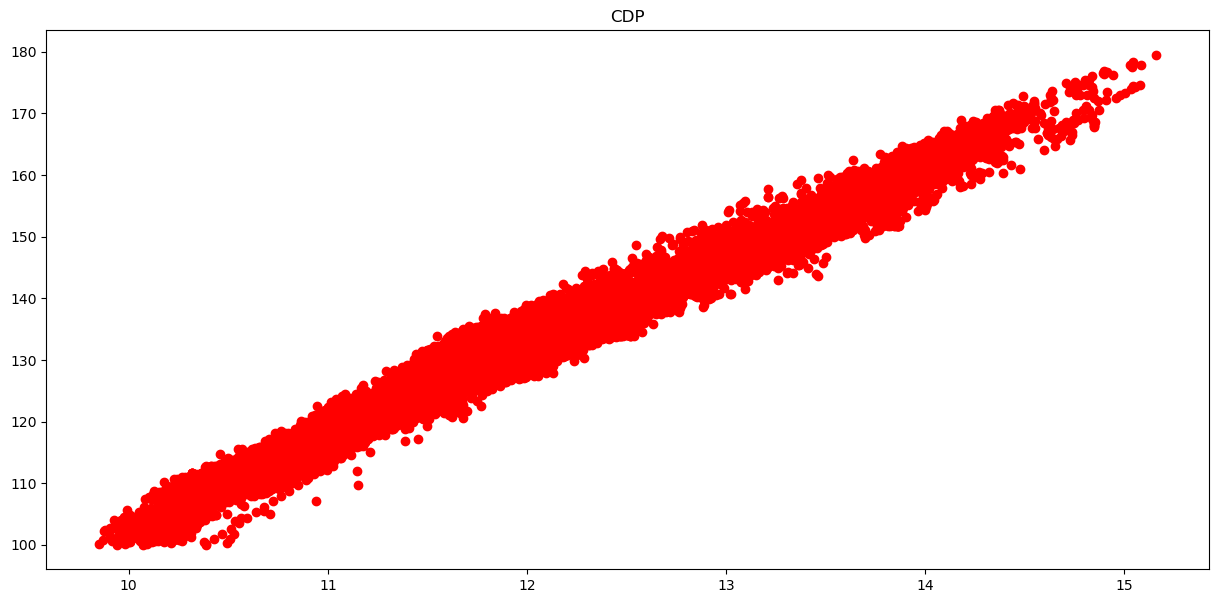

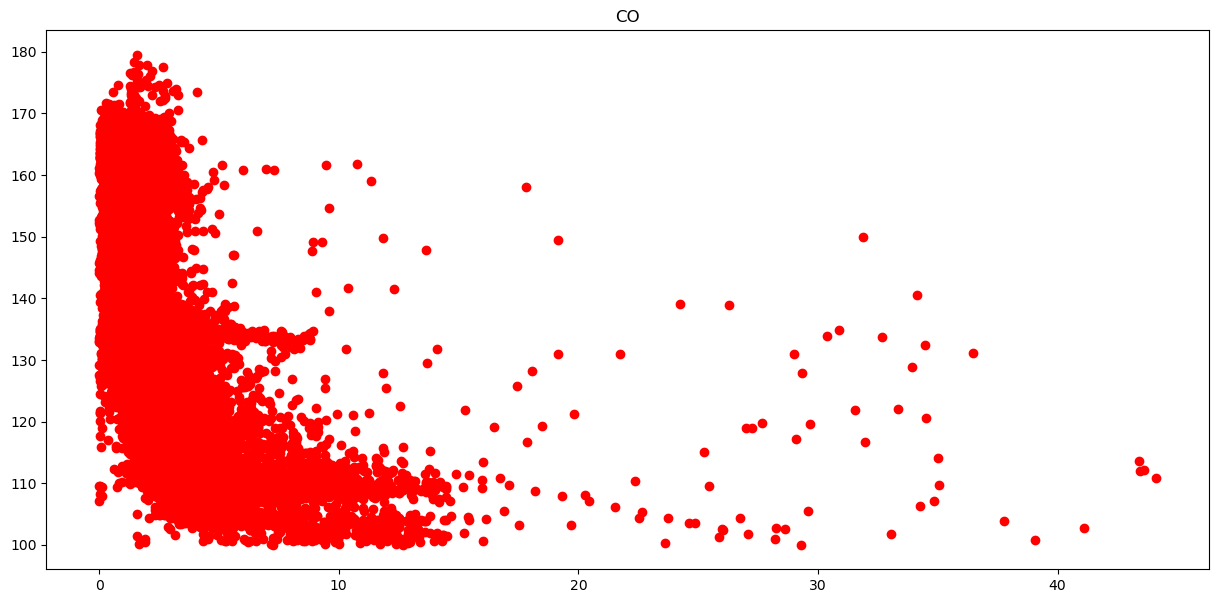

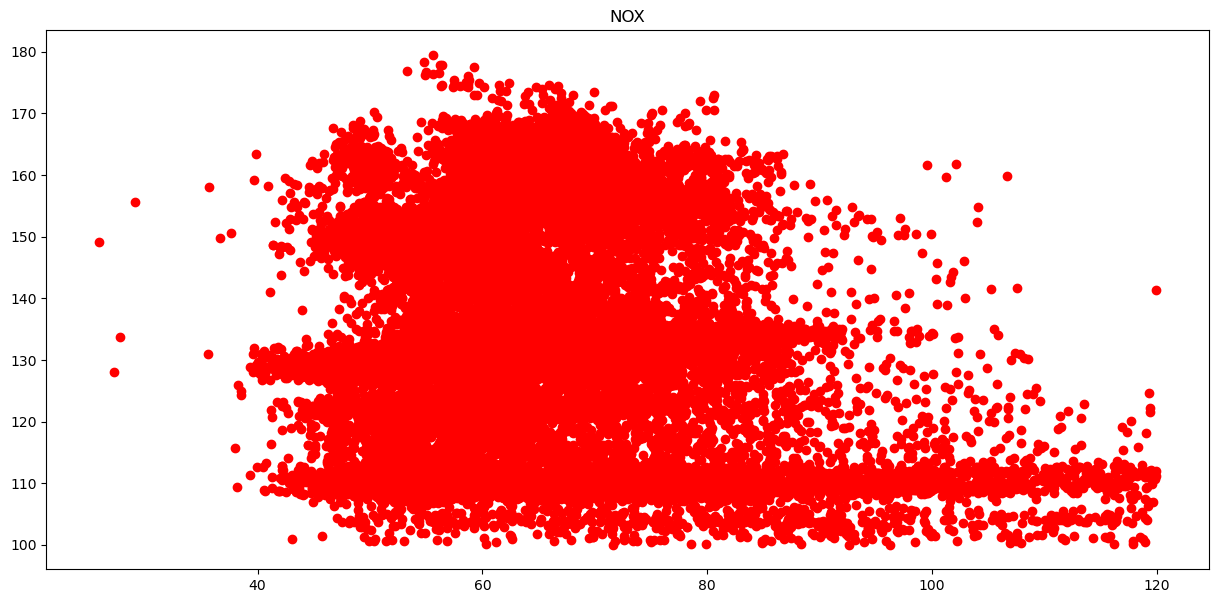

In [43]:
# Plotting the scatter plots of all the numerical variables against the target variable "TEY"
for i in num_cols:
    plt.figure(figsize=(15,7))
    plt.title(i)
    plt.scatter(x=df[i],y=df['TEY'],c='r');

### EDA Observations
### 1. Majority of the observations are in the range 9 to 30 degree celcius with median tempr of 18 degree celcius
### 2. Majority of the observations are in the range 1002 to 1020 mbar pressure values with median pressure value of 1013
### 3. Many of the observations are in the range 62 to 100 percentage in humid values with median humid value of 80
### 4. Almost 70% of the observations have AFDP values between 3 to 5
### 5. GTEP values are a bit scattered approx between the range 5 to 34 with bigger no of values between 22 to 26 with the median value of 25
### 6. TIT values are approx between the range 1050 to 1100 with biggest no of values with 1085 to 1100 & the median value of 1085
### 7. Biggest no of values of TAT are approx between 544 to 551 with the median value of 550
### 8. CDP values are scattered approx between 9 to 15 with biggest no of people approx between 11.7 to 14.1 with median value of 12
### 9. Majority of the CO values are approx between 0 to 8 with median value of 3
### 10. Majority of the NOX values are approx between the range 40 to 90 with median value of 65 approx
### 11. As "CDP" increases, "TEY" increases

### Data Preprocessing
### Handling missing values

In [44]:
# Checking for the missing values in the dataset
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

### Outlier treatment

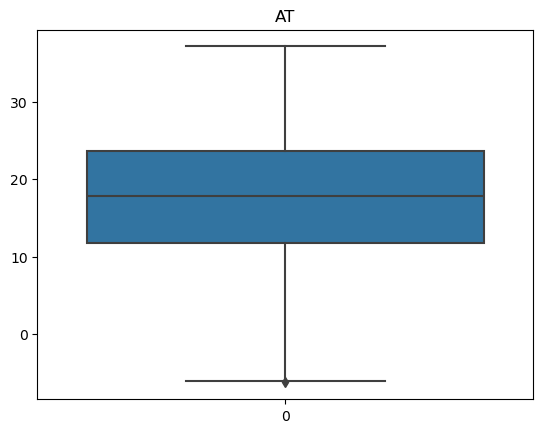

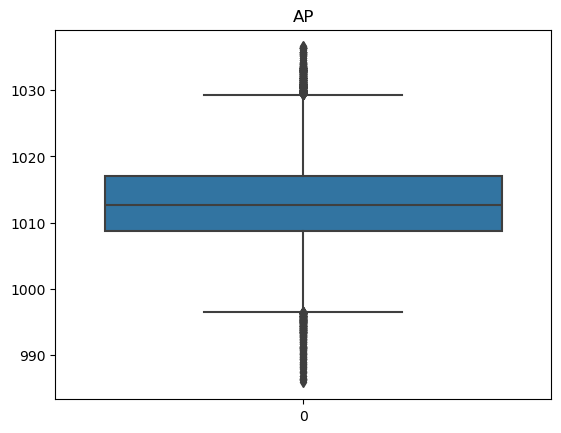

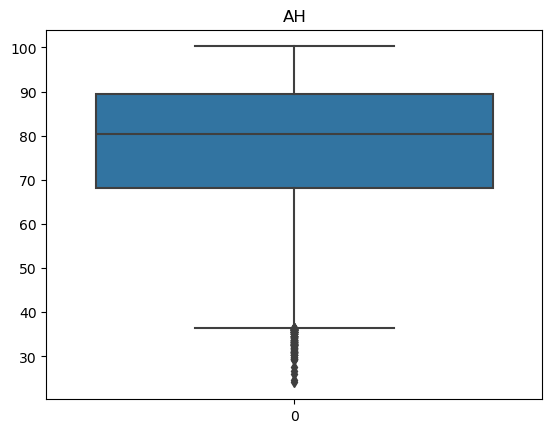

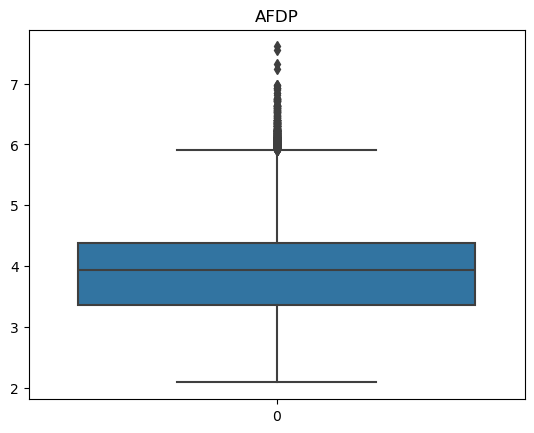

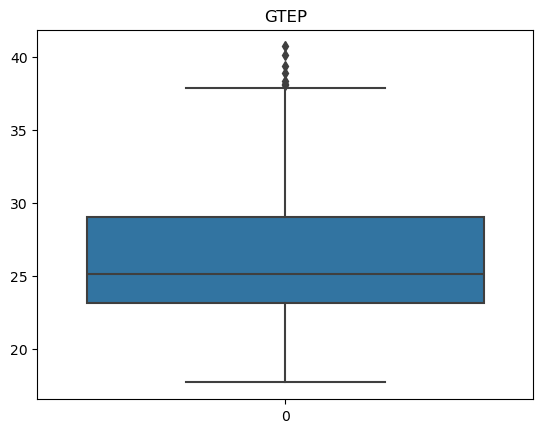

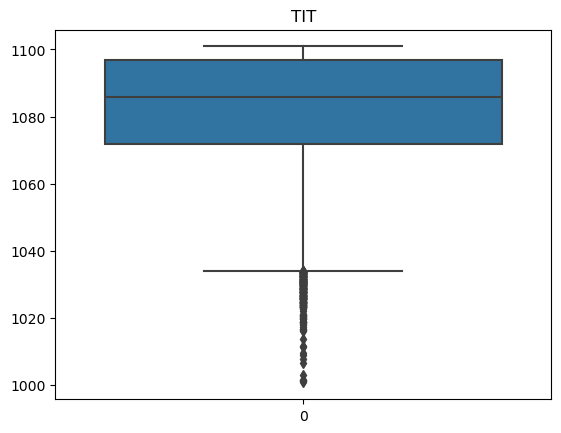

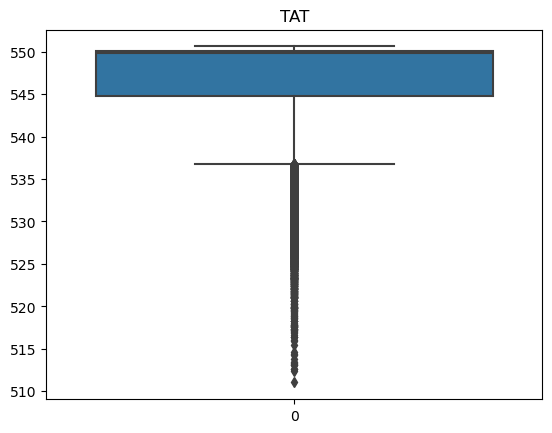

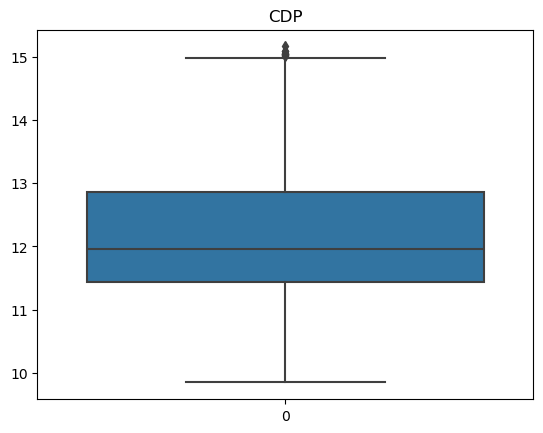

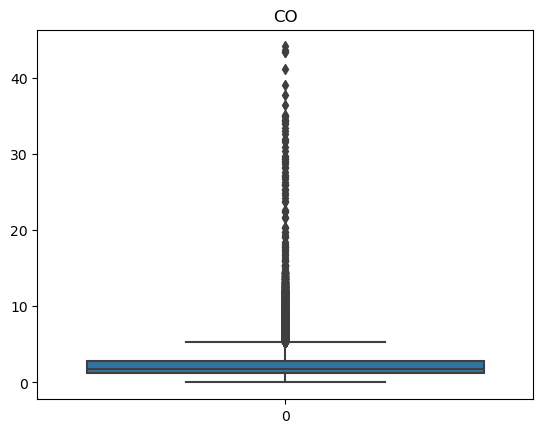

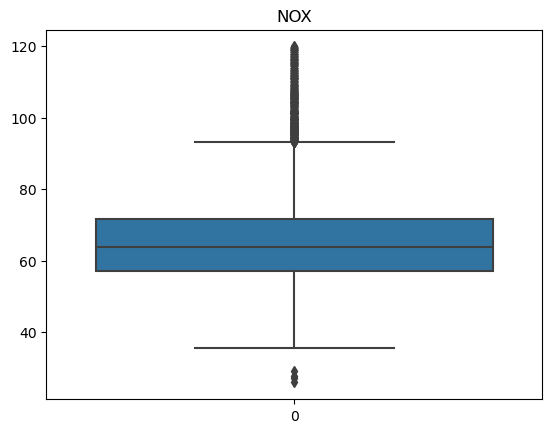

In [45]:
# Plottiing boxplots for outliers
for i in num_cols:
    plt.figure()
    plt.title(i)
    sns.boxplot(df[i]);

In [46]:
# Outlier treatment definition
def outlier_treatment(col):
    q3=np.quantile(df[col],0.75)
    q1=np.quantile(df[col],0.25)
    iqr=q3-q1
    uw=q3+(1.5*iqr)
    lw=q1-(1.5*iqr)
    df[col]=np.where(df[col]>uw,uw,df[col])
    df[col]=np.where(df[col]<lw,lw,df[col])

In [47]:
# Treating the outliers
for i in num_cols:
    outlier_treatment(i)

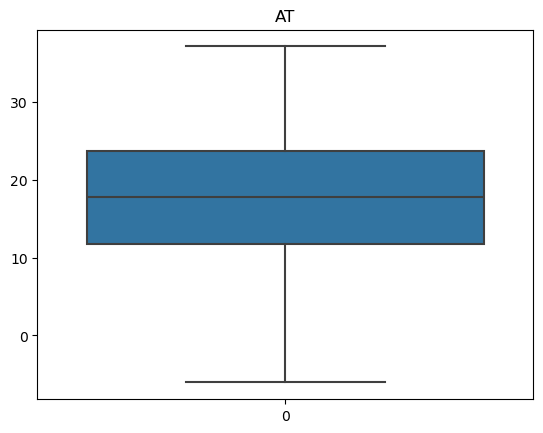

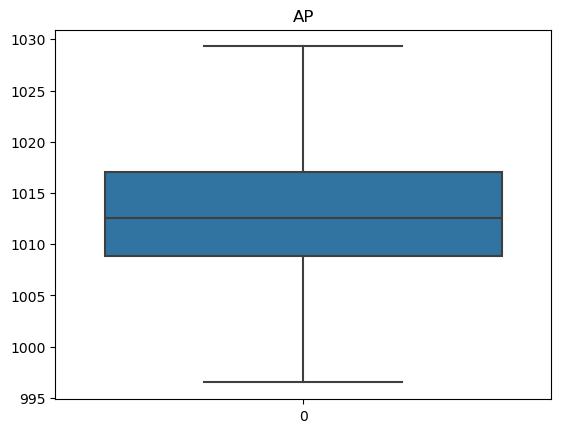

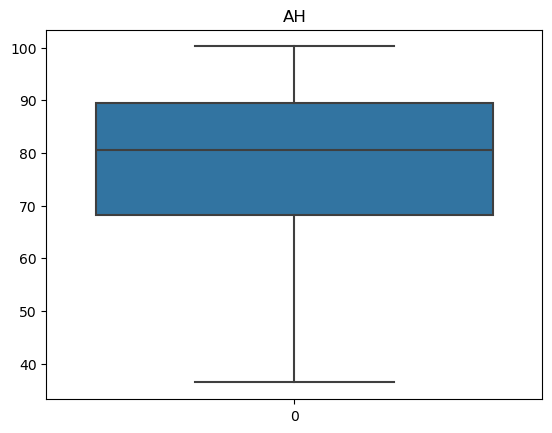

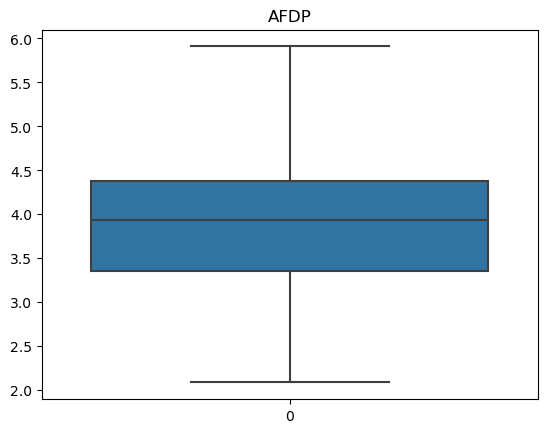

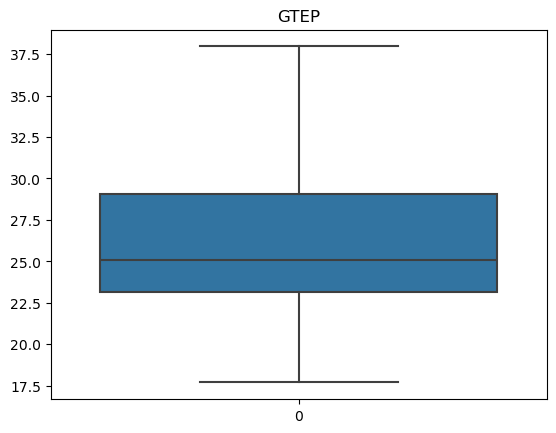

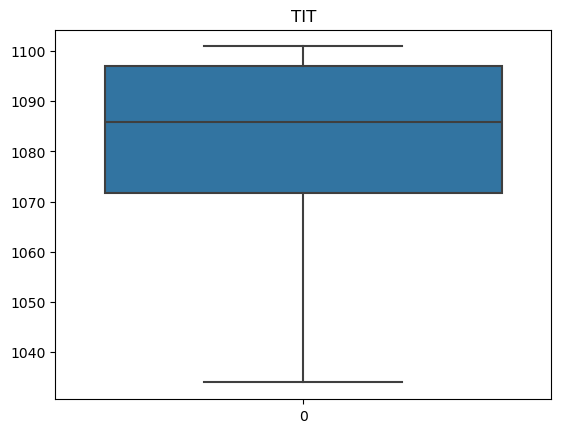

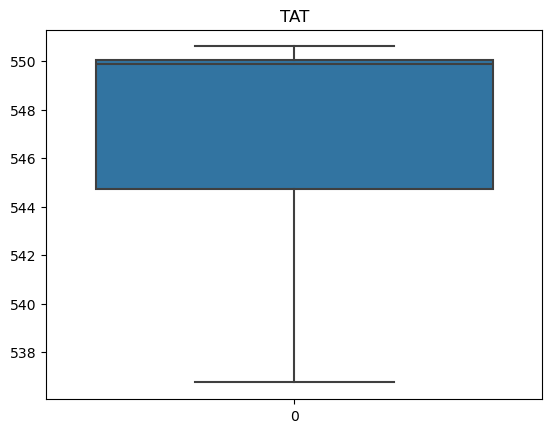

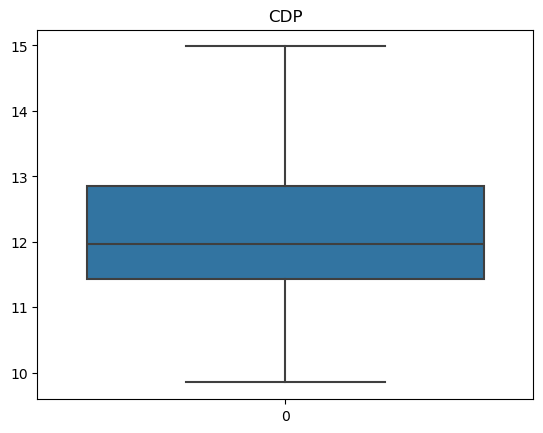

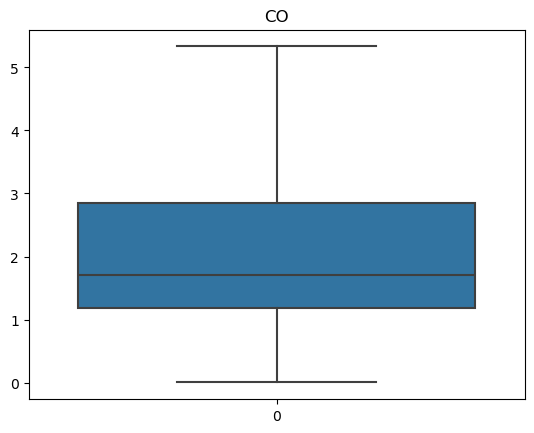

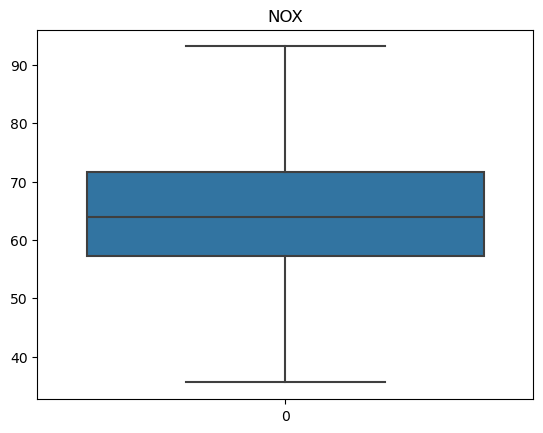

In [48]:
# Checking for the changes
for i in num_cols:
    plt.figure()
    plt.title(i)
    sns.boxplot(df[i]);

In [49]:
# Checking for duplicates
df[df.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
11592,23.156,1004.2,95.938,4.0547,24.672,1076.6,549.87,127.01,11.835,1.7056,47.352
11593,23.156,1004.2,95.938,4.0547,24.672,1076.6,549.87,127.01,11.835,1.7056,47.352
11594,23.156,1004.2,95.938,4.0547,24.672,1076.6,549.87,127.01,11.835,1.7056,47.352
11595,23.156,1004.2,95.938,4.0547,24.672,1076.6,549.87,127.01,11.835,1.7056,47.352
12582,26.067,1008.3,87.328,5.0703,29.984,1099.1,546.78,146.14,13.038,1.3163,52.564
12583,26.067,1008.3,87.328,5.0703,29.984,1099.1,546.78,146.14,13.038,1.3163,52.564
12584,26.067,1008.3,87.328,5.0703,29.984,1099.1,546.78,146.14,13.038,1.3163,52.564


In [50]:
# Dropping the duplicates
df.drop_duplicates(keep='first',inplace=True)

In [51]:
# Checking for the changes
df[df.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


### Preprocessing observations
### 1. There are no missing values in the dataset
### 2. Dataset has columns with outliers. Outlier treatment is necessary
### 3. There are no duplicates in the dataset
### 4. Feature scaling is necessary as the variables are in multiple scales

In [52]:
# Creating the list of independent variables & dependent variable
x=df.drop(columns='TEY')
y=df['TEY']

In [53]:
# Train-test-splitting the dataset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [54]:
# Viewing the first five rows of x_train
x_train.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
19166,22.915,1011.4,77.979,3.7928,21.226,1065.8,549.96,10.863,3.00680,55.585
4262,28.354,1014.1,65.555,4.3525,29.703,1099.9,545.56,13.130,1.39160,53.634
2106,14.985,1015.9,74.831,3.3576,25.834,1078.5,549.87,11.894,3.57410,59.896
35033,20.799,1012.9,83.811,3.9028,25.156,1089.6,550.06,12.040,0.73405,59.834
13847,8.359,1021.0,68.493,3.9111,34.293,1100.1,536.74,14.078,0.39398,58.470


In [55]:
# Viewing the first five rows of x_test
x_test.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
27403,23.2000,1016.4,85.596,4.3828,25.526,1091.1,550.35,12.191,2.83840,64.987
24020,18.4800,1011.8,91.481,4.1958,18.433,1045.1,547.52,10.076,5.33365,81.644
18548,25.3470,1010.1,70.032,4.2657,25.874,1092.5,550.30,12.241,0.85196,62.980
25711,27.8820,1006.8,88.217,4.2583,25.906,1091.3,549.59,12.126,1.30090,54.154
7838,6.4729,1029.3,87.781,3.5294,24.707,1080.0,550.09,12.085,0.84539,64.725


In [56]:
# Shape of x_train
x_train.shape

(29380, 10)

In [57]:
# Shape of x_test
x_test.shape

(7346, 10)

In [58]:
# Min Max Scaling
mn=MinMaxScaler()
for i in x_train.columns:
    x_train[i]=mn.fit_transform(x_train[[i]])
    x_test[i]=mn.transform(x_test[[i]])

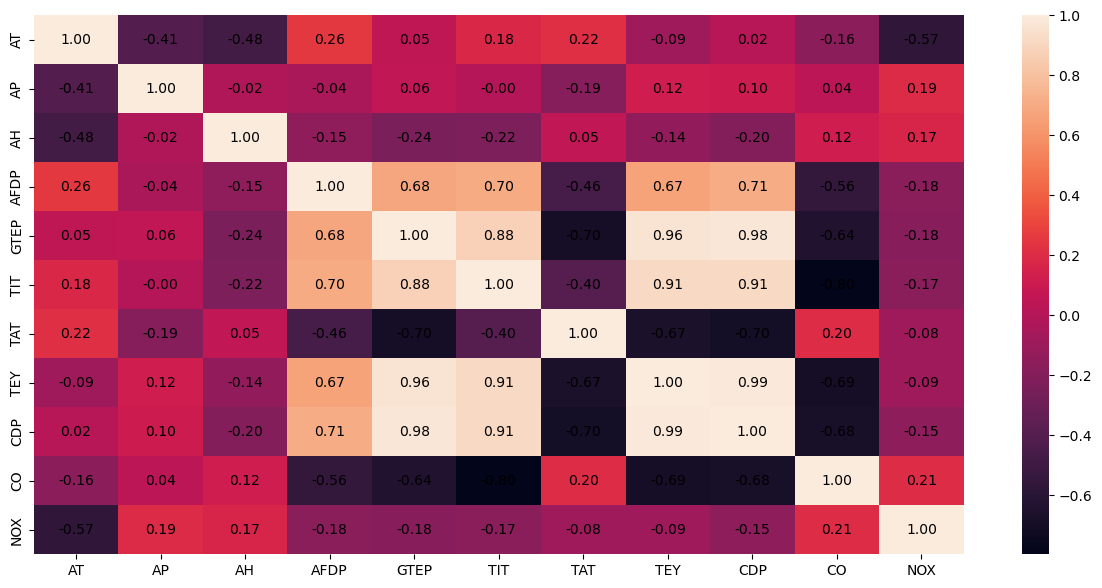

In [59]:
# Correlation Matrix to check for multicollinearlity
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=False)
for i in range(len(df.corr())):
    for j in range(len(df.corr().columns)):
        plt.text(j + 0.5, i + 0.5, f"{df.corr().iloc[i, j]:.2f}", ha='center', va='center')

### There are quite a no of features that are highly correlated with each other.
### Lets go ahead & drop them TIT, GTEP, AFDP as they are highly correlated with each other.

In [60]:
# Dropping the aforesaid highly correlated columns from the dataset 'df'
x_train.drop(columns=['TIT', 'GTEP', 'AFDP'],inplace=True)
x_test.drop(columns=['TIT', 'GTEP', 'AFDP'],inplace=True)

In [61]:
# Checking for the changes
x_train.head()

,AT,AP,AH,TAT,CDP,CO,NOX
19166,0.670677,0.454268,0.651676,0.953136,0.196992,0.563710,0.347595
4262,0.796924,0.536585,0.456924,0.635905,0.638627,0.260856,0.313690
2106,0.486611,0.591463,0.602329,0.946647,0.397842,0.670080,0.422511
35033,0.621562,0.500000,0.743095,0.960346,0.426284,0.137564,0.421434
13847,0.332812,0.746951,0.502978,0.000000,0.823307,0.073800,0.397730


In [62]:
# Checking for the changes
x_test.head()

,AT,AP,AH,TAT,CDP,CO,NOX
27403,0.677292,0.606707,0.771076,0.981255,0.455700,0.532134,0.510983
24020,0.567734,0.466463,0.863326,0.777217,0.043676,1.000000,0.800448
18548,0.727127,0.414634,0.527103,0.977650,0.465441,0.159672,0.476105
25711,0.785968,0.314024,0.812161,0.926460,0.443037,0.243849,0.322727
7838,0.289033,1.000000,0.805327,0.962509,0.435050,0.158440,0.506430


In [63]:
y_train.head()

19166    115.55
4262     147.00
2106     131.46
35033    133.66
13847    162.67
Name: TEY, dtype: float64

In [64]:
y_test.head()

27403    133.64
24020    103.71
18548    134.60
25711    132.82
7838     133.98
Name: TEY, dtype: float64

## Model building
### Ridge Regression

In [65]:
# Creating a Ridge Regression model
ridgemodel=Ridge()
ridgemodel.fit(x_train,y_train)

Ridge()

In [66]:
# Predicting using Ridge Regression
ridgepredictions=ridgemodel.predict(x_test)

In [67]:
# r2_score on y_test data
r2_score(y_test,ridgepredictions)

0.9947027634429836

In [68]:
# r2_score on y_train to check for overfitting
r2_score(y_train,ridgemodel.predict(x_train))

0.9946807807659739

In [69]:
# To know the no of observations in the final dataset 
pd.concat([x_train,x_test]).shape

(36726, 7)

In [70]:
# Adjusted R2 score on y_test data
1-((1-r2_score(y_test,ridgepredictions))*(36726-1))/(36726-7-1)

0.9947017535661956

### Model is not overfitted

In [71]:
# Cross-validation with 5 splits
riscores=cross_val_score(Ridge(),pd.concat([x_train,x_test]),pd.concat([y_train,y_test]),cv=5)
print(riscores)
print(np.mean(riscores))
adjriscores=[]
for i in riscores:
    adjriscores.append(1-(((1-i)*(36726-1))/(36726-7-1)))
print(adjriscores)
print(sum(adjriscores)/len(adjriscores))

[0.99464254 0.9945691  0.99468794 0.99479798 0.99470299]
0.9946801100649211
[0.9946415185789299, 0.9945680695294672, 0.9946869262056734, 0.9947969878804908, 0.9947019771526558]
0.9946790958694434


### Model's performance is consistent across splits

In [72]:
# Coefficients of the independent variables
ridgemodel.coef_

array([-12.67315944,  -2.31411181,  -0.24913669,   3.71885592,
        76.21961064,  -1.56862708,   0.44355197])

In [73]:
# Independent columns
x_train.columns

Index(['AT', 'AP', 'AH', 'TAT', 'CDP', 'CO', 'NOX'], dtype='object')

### As per Ridge regression, coefficient of CDP is the highest indicating that CDP is most important variable in predicting TEY

### Random Forest

In [74]:
# Random Forest Regressor
rmodel=RandomForestRegressor().fit(x_train,y_train)

In [75]:
# Predicting using RF Regressor
rpredictions=rmodel.predict(x_test)

In [76]:
# R2 score on test data
r2_score(y_test,rpredictions)

0.9969528283302684

In [77]:
# R2 score on train data
r2_score(y_train,rmodel.predict(x_train))

0.9995935124049532

In [78]:
# Adjusted r2 score on test data set
1-((1-r2_score(y_test,rpredictions))*(36726-1))/(36726-7-1)

0.9969522474107824

### Model is not overfitted

In [79]:
# Cross_validation
rfscores=cross_val_score(RandomForestRegressor(),pd.concat([x_train,x_test]),pd.concat([y_train,y_test]),cv=5,n_jobs=-1)
print(rfscores)
print(np.mean(rfscores))
adjrfscores=[]
for i in rfscores:
    adjrfscores.append(1-(((1-i)*(36726-1))/(36726-7-1)))
print(adjrfscores)
print(sum(adjrfscores)/len(adjrfscores))

[0.9970591  0.99700009 0.99720652 0.99722065 0.99695248]
0.9970877690559596
[0.997058540333782, 0.9969995161011651, 0.9972059892176444, 0.9972201212278602, 0.9969519024288952]
0.9970872138618694


### Takeaway - Model's performance is consistent across various splits

In [80]:
# Creating a dataframe with feature names & feature importances
pd.DataFrame(data=rmodel.feature_importances_,index=rmodel.feature_names_in_,columns=['Feature_Importances']).sort_values(by='Feature_Importances',ascending=False)

,Feature_Importances
CDP,0.984523
AT,0.008420
NOX,0.004126
TAT,0.000894
CO,0.000751
AP,0.000691
AH,0.000594


### Feature Importances attribute of the Random Forest model indicates that "CDP" is the most important variable helpful in determining "TEY" followed by distant "AT"

## SHAP Analysis - Model Interpretability

In [81]:
# Creating a Fasttree explainer object
explainer=fasttreeshap.TreeExplainer(rmodel,algorithm='auto',n_jobs=-1)

In [82]:
# Converting the x_test into a list
instances=[x_test.iloc[i] for i in range(len(x_test))]

In [83]:
# Initializing the batch size for batch wise processing for shap values calculation
batch_size=100

In [84]:
# Calculating the shap values for an batch wise using parallel processing
shap_values_list = Parallel(n_jobs=2, backend="loky")(
    delayed(explainer.shap_values)(np.array(instances[i:i + batch_size])) for i in range(0, len(instances), batch_size))

In [85]:
# Concatenating multiple arrays (shap_values_list) of into a single array for summary plot
shap_values_concat = np.vstack(shap_values_list)

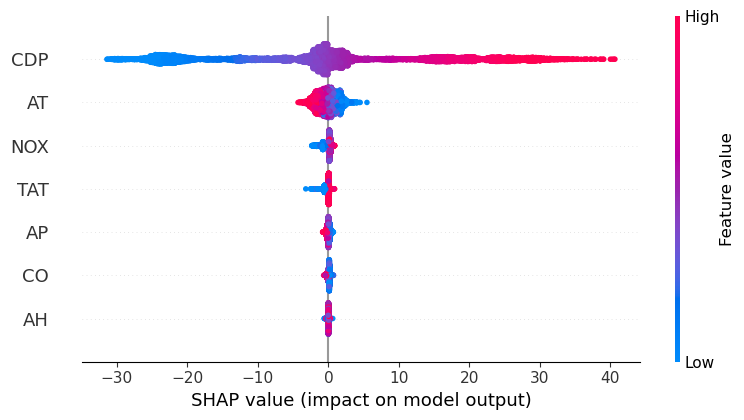

In [86]:
# Plotting the summary plot for x_test
shap.summary_plot(shap_values_concat,x_test,feature_names=x_test.columns)

## Findings from the Model/Analysis
## Even the Shap Analysis indicates the same as other models i.e. CDP as the important variable in determining TEY. Higher the value of CDP more would be the value of TEY
## Followed by distant AT. It might be of a very little help in predicting the output of a turbine. Lower are its values mean a little higher values of TEY & Vice Versa

## We would recommend the client to focus on the values of CDP to predict the turbine's yield output